<a href="https://colab.research.google.com/github/Dinh-Xuan-Huong/TED/blob/main/TED_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install scikit_posthocs

In [3]:
import numpy as np
import pandas as pd
import math
import os
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
sns.set()

# Set working dir
os.chdir('/content/drive/MyDrive/TED/TED_scraping')

In [4]:
def open_json(json_path):
    with open(json_path) as f:
        data = json.load(f)
    return (data)

# Load data (json)

In [ ]:
# All videos in TED channel until Nov, 12th 2020
video_urls = open_json('./data/all_video_links.json')
print(f"There are total {len(video_urls)} videos on TED youtube channel until Nov, 12th 2020.")

There are total 3514 videos on TED youtube channel until Nov, 12th 2020.


In [ ]:
# Data path 
data1_path = './data/update_video_info_COLAB_0.json'  # video from 0 to 999
data2_path = './data/update_video_info_COLAB_1.json'  # video from 1000 to 2121
data3_path = './data/update_video_info_COLAB_3.json'  # videos which are also in playlist (1393 videos)

# Load all data
data1 = open_json(data1_path)
data2 = open_json(data2_path)
data3 = open_json(data3_path)

# Merge all of these data set into one dataset
data = data1 + data2 + data3
print(f"The dataset contains information of total {len(data)} videos.")

The dataset contains information of total 3514 videos.


In [ ]:
# Convert to dataframe
df = pd.DataFrame(data)
df.drop(columns="id", inplace=True)
df.rename(columns={"puplic_date": "public_date"}, inplace=True)
df.head()

,title,yid,public_date,event,nview,nlike,ndislike,ncomment
0,Our immigration conversation is broken -- here...,sf3adAPotrM,"Dec 2, 2019",TED,"49,388 views",866 likes,438 dislikes,380 Comments
1,Evan Grant: Making sound visible through cymatics,CsjV1gjBMbQ,"Sep 9, 2009",TED,"247,133 views","2,374 likes",66 dislikes,240 Comments
2,Chrystia Freeland: The rise of the new global ...,d6NKdnZvdoo,"Sep 5, 2013",TED,"373,356 views","4,721 likes",944 dislikes,"1,807 Comments"
3,Reducing corruption takes a specific kind of i...,jltYcaQ24q4,"Oct 28, 2019",TED,"38,299 views","1,651 likes",31 dislikes,127 Comments
4,What if gentrification was about healing commu...,M5PiTCwoQRo,"Apr 12, 2018",TED,"66,423 views","1,231 likes",608 dislikes,331 Comments


In [ ]:
df.to_csv('./data/TED_youtube.csv', index=False)

# CSV dataset

In [61]:
df = pd.read_csv('./data/TED_youtube.csv')

In [62]:
# DataFrame type
df.dtypes

title          object
yid            object
public_date    object
event          object
nview          object
nlike          object
ndislike       object
ncomment       object
dtype: object

---
The dataset columns are all object. So now I am going to change the type of each column to its suitable type. This step will make the further EDA step getting more convenient.

---

# Datatype format

## Date type

In [63]:
# Date format '%b %d, %Y'
def date_format(df, date_column):
  """
  Find all the formats of public_date that does not follow '%b %d, %Y.
  Return error rows.
  """
  error_rows = []
  for row in range(len(df)):
    try:
      datetime.strptime(df[date_column].loc[row], '%b %d, %Y')
    except ValueError:
      error_rows.append(row)

  return (error_rows if len(error_rows) > 0 else None)

In [64]:
error_date_format = date_format(df, "public_date")
df["public_date"].loc[error_date_format]

1105         Published on Sep 9, 2020
1872         Published on Sep 5, 2019
2020    Streamed live on Oct 10, 2020
2261        Published on Sep 13, 2017
2575        Published on Nov 21, 2013
Name: public_date, dtype: object

In [65]:
# Re-format
df['public_date'].loc[error_date_format] = df['public_date'].loc[error_date_format].str.split(" on ")
df['public_date'].loc[error_date_format] = df['public_date'].loc[error_date_format].apply(lambda date: date[1])
df["public_date"] = pd.to_datetime(df['public_date'], format='%b %d, %Y')

In [66]:
df.dtypes

title                  object
yid                    object
public_date    datetime64[ns]
event                  object
nview                  object
nlike                  object
ndislike               object
ncomment               object
dtype: object

## Numeric

In [67]:
# None value in these columns are actually 0
df.loc[df["nlike"].isna(), ["nlike", "ndislike"]] = 0

In [68]:
# Views
df["nview"] = df["nview"].map(lambda v: int(str(v).split(" ")[0].replace(",", "")))

# Likes
df["nlike"] = df["nlike"].map(lambda v: int(str(v).split(" ")[0].replace(",", "")))

# Dislikes
df["ndislike"] = df["ndislike"].map(lambda v: int(str(v).split(" ")[0].replace(",", "")))

# Comments
df.loc[df["ncomment"] != "Off", "ncomment"] = df.loc[df["ncomment"] != "Off", "ncomment"].map(lambda v: int(str(v).split(" ")[0].replace(",", "")))

# Get speaker

In [69]:
def get_speaker_from_title(dataframe, title_colname, speaker_colname):
  df = dataframe.copy()
  # Index of title which contains ":"
  colon_idx = df[df[title_colname].str.contains(":")].index

  # Index of title which contains vertical bar "|"
  verbar_idx = df[df[title_colname].str.contains("\|")].index
  
  # Speaker name will be after | if the title contains "|"
  df.loc[verbar_idx, speaker_colname] = df.loc[verbar_idx, title_colname].map(lambda t: t.split(" | ")[1]) # Speaker
  df.loc[verbar_idx, title_colname] = df.loc[verbar_idx, title_colname].map(lambda t: t.split(" | ")[0]) # Standard title

  # Speaker name will be before ":" if the title contains ONLY ":"
  only_colon_idx = list(set(colon_idx) - set(colon_idx).intersection(set(verbar_idx)))
  df.loc[only_colon_idx, speaker_colname] = df.loc[only_colon_idx, title_colname].map(lambda t: t.split(": ", 1)[0]) # Speaker
  df.loc[only_colon_idx, title_colname] = df.loc[only_colon_idx, title_colname].map(lambda t: t.split(": ", 1)[1]) # Standard title
  return df



In [70]:
# Create speaker column
df["speaker"] = ""

# Get speaker name
df = get_speaker_from_title(df, 'title', 'speaker')

# Remove unwanted characters such as ":" from speaker name
df['speaker'] = df['speaker'].map(lambda x: x.rstrip(":"))

In [71]:
# Remove "" from title
df['title'] = df['title'].map(lambda x: x.rstrip("\"").lstrip("\""))

# EDA

In [72]:
# Change values of 'ncomment' == "Off" to 0
df.loc[df['ncomment'] == "Off", 'ncomment'] = 0
df['ncomment'] = df['ncomment'].astype('int64')

In [73]:
df.head()

,title,yid,public_date,event,nview,nlike,ndislike,ncomment,speaker
0,Our immigration conversation is broken -- here...,sf3adAPotrM,2019-12-02,TED,49388,866,438,380,Paul A. Kramer
1,Making sound visible through cymatics,CsjV1gjBMbQ,2009-09-09,TED,247133,2374,66,240,Evan Grant
2,The rise of the new global super-rich,d6NKdnZvdoo,2013-09-05,TED,373356,4721,944,1807,Chrystia Freeland
3,Reducing corruption takes a specific kind of i...,jltYcaQ24q4,2019-10-28,TED,38299,1651,31,127,Efosa Ojomo
4,What if gentrification was about healing commu...,M5PiTCwoQRo,2018-04-12,TED,66423,1231,608,331,Liz Ogbu


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3514 entries, 0 to 3513
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        3514 non-null   object        
 1   yid          3514 non-null   object        
 2   public_date  3514 non-null   datetime64[ns]
 3   event        3514 non-null   object        
 4   nview        3514 non-null   int64         
 5   nlike        3514 non-null   int64         
 6   ndislike     3514 non-null   int64         
 7   ncomment     3514 non-null   int64         
 8   speaker      3514 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 247.2+ KB


---
**DATASET GENERAL INFO**
- There is no missing value in this dataset.
- The dataset contains 9 attributes and 3514 entries. This dataset was scraped in Nov 12nd, 2020.
  - "title": video title
  - "yid": the ID of this video on youtube platform
  - "public_date": the date the video was uploaded
  - "event": TED/TEDx or TEDPartner, etc. where the talk took place
  - "nview": number of views of the video until the scrape date
  - "nlike": number of likes of the video until the scrape date
  - "ndislike": number of dislikes of the video until the scrape date
  - "ncomment": number of comments of the video until the scrape date
  - "speaker": persons who give talk. It could be more than one speak for each talk.
- After the datatype transformation, now:
  - "public_date" has datetime values
  - "nview", "nlike" and "ndislike" are numeric values
  - "ncomment" = 0 means this talk turned off comment 
  - The remaining features are object or string
---

## First and lated TED videos posted on Youtube until Nov 12, 2020

In [75]:
# First and last public_date according to the dataset
index_df_sort_by_date = df.sort_values(by=['public_date'], ascending=True, inplace=False).index
print("{} is the first TED video posted on youtube in {}".format(df.loc[index_df_sort_by_date[0], 'title'],
                                                                 df.loc[index_df_sort_by_date[0], 'public_date']),
      "{} is the lated TED video posted on youtube in {}".format(df.loc[index_df_sort_by_date[-1], 'title'],
                                                                 df.loc[index_df_sort_by_date[-1], 'public_date']),
      sep='\n'
      )

If I controlled the Internet is the first TED video posted on youtube in 2006-12-25 00:00:00
To save the climate, we have to reimagine capitalism is the lated TED video posted on youtube in 2020-11-11 00:00:00


## Numeric columns dispersion

In [76]:
df.describe()

,nview,nlike,ndislike,ncomment
count,3.514000e+03,3.514000e+03,3514.000000,3514.000000
mean,5.524925e+05,9.952337e+03,500.505122,812.747012
std,1.918630e+06,3.967789e+04,1557.841968,3027.886063
min,5.388000e+03,0.000000e+00,0.000000,0.000000
25%,6.081750e+04,9.552500e+02,55.000000,105.000000
50%,1.107025e+05,1.974000e+03,118.000000,212.000000
75%,2.695998e+05,4.385250e+03,307.000000,460.500000
max,3.326082e+07,1.191320e+06,35777.000000,108459.000000


In [77]:
df[df['nview'] < 0.6e+06].describe()

,nview,nlike,ndislike,ncomment
count,3005.000000,3005.000000,3005.000000,3005.000000
mean,133792.718136,2337.638270,218.366057,273.548419
std,116914.230600,2491.691019,576.880728,346.490725
min,5388.000000,0.000000,0.000000,0.000000
25%,54824.000000,831.000000,49.000000,93.000000
50%,93259.000000,1608.000000,94.000000,178.000000
75%,167738.000000,2908.000000,202.000000,321.000000
max,599858.000000,27597.000000,16771.000000,6624.000000


In [78]:
df.skew()

nview        9.169849
nlike       13.498755
ndislike     8.960272
ncomment    17.416239
dtype: float64

---
**NUMERIC ATTRIBUTES DISPERSION**
- From the aboved table, we see that all these numeric features are right (or positive) skewness. In other word, it indicates an asymmetry in the distribution and the tail is larger towards the right hand side of the distribution.
- A possible reason to explain this is that the value of "nview", "nlike" and "ndislike" are cumulative count. Some videos which were posted at early day likely have more views (or interaction) than those posted later.
- Hence, it is better to compare when they are in a same time-scale. 
---

## Add attributes

In [79]:
def FindDay(date_list):
  week_days = list(map(lambda date: calendar.day_name[date.weekday()], date_list))
  return (week_days)

In [80]:
def count_day(start_day, end_days):
  counts = start_day - end_days
  counts = list(map(lambda x: x.days, counts))
  return (counts)

In [132]:
df['year'] = df['public_date'].dt.year
df['month'] = df['public_date'].dt.month
df['week_day'] = FindDay(df['public_date'])
df['nview_per_like'] = df['nview']/df['nlike']
df['nview_per_dislike'] = df['nview']/df['ndislike']
df['nday'] = count_day(datetime(2020, 11, 12), df['public_date'])
df['nview_per_day'] = df['nview']/df['nday']
df['nview_per_comment'] = df['nview']/df['ncomment']
# df['nview_per_comment'] = [df.loc[i, 'nview']/df.loc[i, 'ncomment'] if df.loc[i, 'ncomment'] != "Off" else np.nan for i in range(len(df))]

In [133]:
df.head(5)

,title,yid,public_date,event,nview,nlike,ndislike,ncomment,speaker,year,month,week_day,nview_per_like,nview_per_dislike,nday,nview_per_day,rank_nview,rank_nlike,rank_ndislike,rank_ncomment,rank_nview_per_like,rank_nview_per_dislike,nview_per_comment
0,Our immigration conversation is broken -- here...,sf3adAPotrM,2019-12-02,TED,49388,866,438,380,Paul A. Kramer,2019,12,Monday,57.030023,112.757991,346,142.739884,2886.0,2722.0,670.0,1060.0,1564.0,139.0,129.968421
1,Making sound visible through cymatics,CsjV1gjBMbQ,2009-09-09,TED,247133,2374,66,240,Evan Grant,2009,9,Wednesday,104.099832,3744.439394,4082,60.542136,939.0,1509.0,2447.0,1605.0,2807.0,3192.0,1029.720833
2,The rise of the new global super-rich,d6NKdnZvdoo,2013-09-05,TED,373356,4721,944,1807,Chrystia Freeland,2013,9,Thursday,79.084092,395.504237,2625,142.230857,695.0,834.0,362.0,281.0,2302.0,584.0,206.616491
3,Reducing corruption takes a specific kind of i...,jltYcaQ24q4,2019-10-28,TED,38299,1651,31,127,Efosa Ojomo,2019,10,Monday,23.197456,1235.451613,381,100.522310,3149.0,1977.0,3068.0,2429.0,72.0,1777.0,301.566929
4,What if gentrification was about healing commu...,M5PiTCwoQRo,2018-04-12,TED,66423,1231,608,331,Liz Ogbu,2018,4,Thursday,53.958570,109.248355,945,70.288889,2506.0,2345.0,517.0,1194.0,1438.0,132.0,200.673716


In [83]:
years = np.unique(df['year'])
months = np.unique(df['month'])
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']

## Total TED videos uploaded on Youtube by years

Text(0.5, 1.0, 'Number of TED videos posted on Youtube by Year')

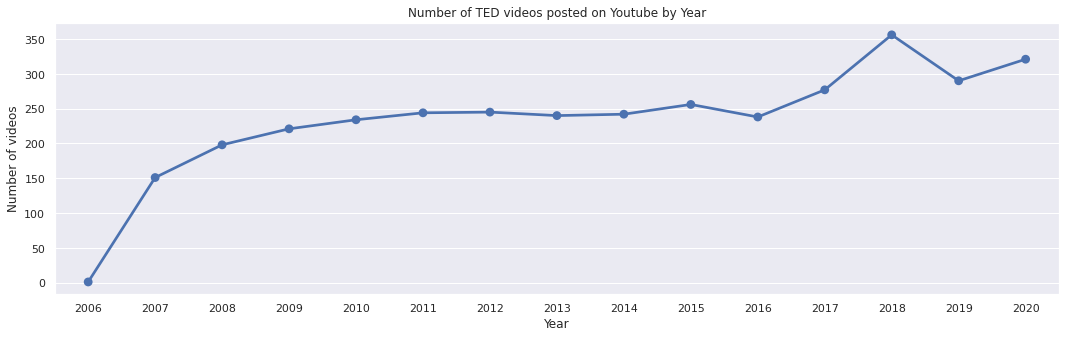

In [84]:
total_videos_per_year = list(df.groupby(df['year'])['title'].count())
plt.figure(figsize=(18,5))
sns.pointplot(x=np.unique(df['year']), y=total_videos_per_year)
plt.xlabel("Year")
plt.ylabel("Number of videos")
plt.title("Number of TED videos posted on Youtube by Year")

---
**Observations**
- After the first video posted on Youtube in Dec 25, 2006, in next years, the quantity of videos had countinuously increased until 2011. From 2011 to 2016, the number of videos uploaded was stable around 250 videos per year. This number was raised 10% in next year before reaching a peak 350 videos in 2018. Posted videos in following years went back to a rate as 2017. 
- The boxplot figure also illustrates that the average number of talks posted per month in 2018 was markedly high compare to others. Since 2010, the average public rate about 20-25 talks/month. 
- 2007, 2011 to 2015 and 2018 have outlier. Among them, in 2007 and 2015, there are some month which the number of public talks lies markedly far outside the range.
- In other years, the quantity of videos is stable for months.   

---

## What are the most/ least popular month?

In [85]:
# df group by year and month
df_title_count= df.copy()
df_title_count = df_title_count.groupby(by=['year', 'month'])['title'].count().rename('total_videos').reset_index()
df_title_count = df_title_count.astype('int32')
df_title_count

,year,month,total_videos
0,2006,12,1
1,2007,1,50
2,2007,3,4
3,2007,4,6
4,2007,5,35
...,...,...,...
162,2020,7,33
163,2020,8,24
164,2020,9,24
165,2020,10,42


In [86]:
# Append values 0 for missing months of each year into df_title_count
mis_value = []
for year in years:
  mis_month = list(set(months) - set(df_title_count.loc[df_title_count['year'] == year, 'month']))
  if mis_month:
    mis_value.extend(list(zip([year]*len(mis_month), mis_month, [0]*len(mis_month))))

df_title_count = df_title_count.append(pd.DataFrame(mis_value, columns=['year', 'month', 'total_videos']), ignore_index = True)

df_title_count = df_title_count.sort_values(by=['year', 'month'], ascending=True).reset_index(drop=True)

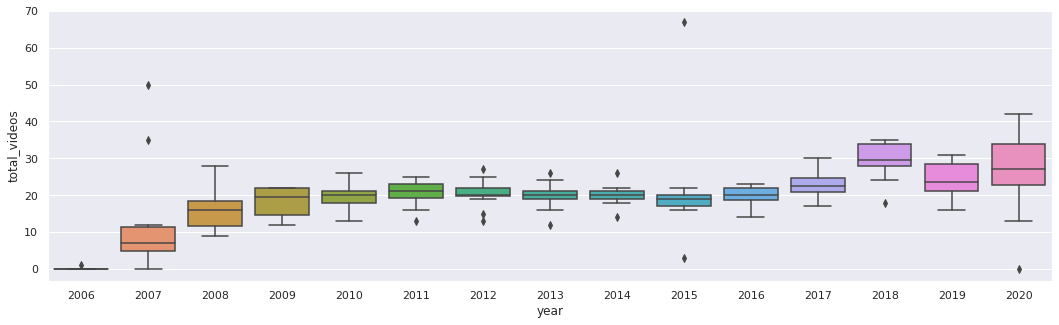

In [87]:
plt.figure(figsize=(18,5))
ax = sns.boxplot(x="year", y="total_videos", data=df_title_count)

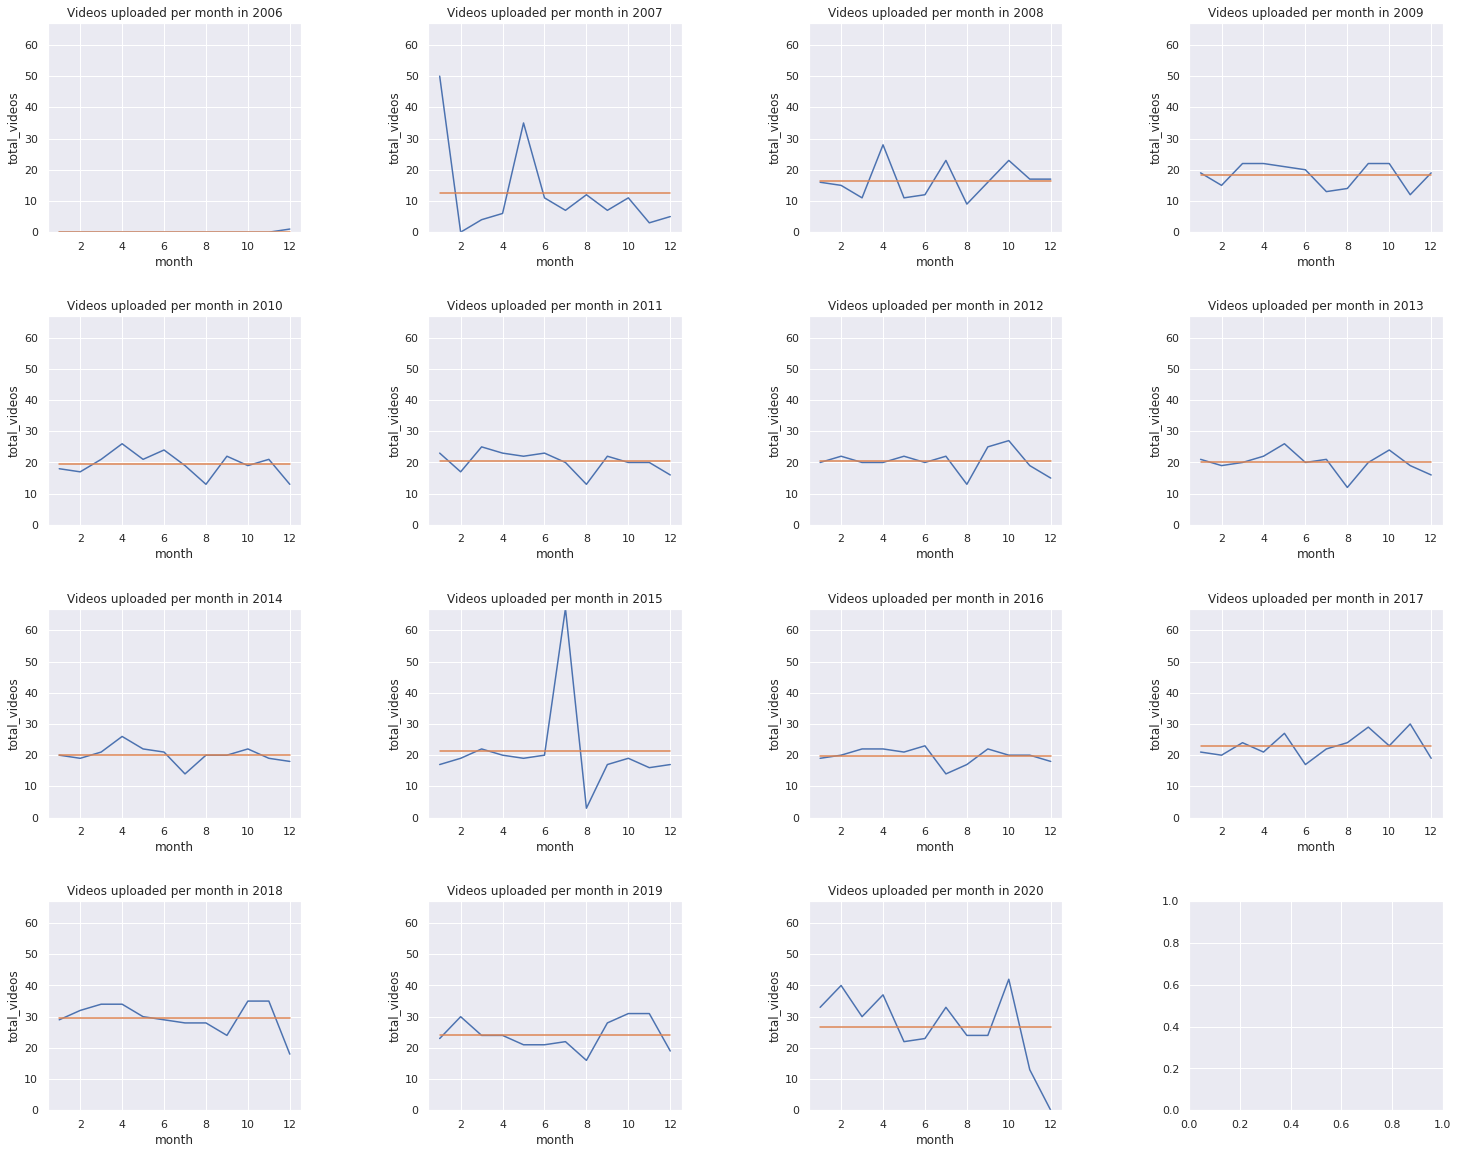

In [88]:
def plot_video_count_per_year(df_title_count):
  years = np.unique(df_title_count['year'])
  months = np.unique(df_title_count['month'])
  fig, axes = plt.subplots(4, 4, figsize=(25, 20))
  fig.subplots_adjust(hspace=0.4, wspace=0.5)
  # fig.suptitle('Number of posted videos in each years')
  i, j = 0 , 0
  for year in years:
    df_year = df_title_count[df_title_count['year'] == year]
    sns.lineplot(data = df_year, x = "month", y="total_videos", ax=axes[i, j])
    sns.lineplot(x = months, y = [df_year['total_videos'].mean()]*12, ax=axes[i, j])
    axes[i, j].set_title(f"Videos uploaded per month in {year}")
    axes[i, j].set_ylim(0, df_title_count['total_videos'].max())
    if j == 3:
      i, j = i + 1, 0
    else:
      j = j + 1

plot_video_count_per_year(df_title_count)

---
- In 2007, it is a very first year that TED works on Youtube, hence it can be a reason of why these first months of this year have large quantity of talks.
- In 2015, it revealed an abnormal sharp rise in July - 3 times the average.  

---

In [89]:
# Rank months based on the quantity of public videos from 2008 to 2019
# 12st means this month had largest posted videos
df_title_count['rank'] = ''
for year in np.unique(df_title_count['year']):
  year_index = df_title_count[df_title_count['year'] == year].index
  df_title_count.loc[year_index, 'rank'] = df_title_count.loc[year_index, 'total_videos'].rank(method="max")

df_title_count['rank'] = df_title_count['rank'].astype('int32')

In [90]:
def plot_month_rank(df_title_count):
  # years = np.unique(df_title_count['year'])
  months = np.unique(df_title_count['month'])
  fig, axes = plt.subplots(3, 4, figsize=(25, 20))
  fig.subplots_adjust(hspace=0.4, wspace=0.5)
  # fig.suptitle('Number of posted videos in each years')
  i, j = 0 , 0
  for month in months:
    df_month = df_title_count[df_title_count['month'] == month]
    sns.countplot(data = df_month, x = "rank", ax=axes[i, j])
    axes[i, j].set_title(f"Rank distribution of {month}")
    # axes[i, j].set_ylim(0, df_title_count['total_videos'].max())
    if j == 3:
      i, j = i + 1, 0
    else:
      j = j + 1

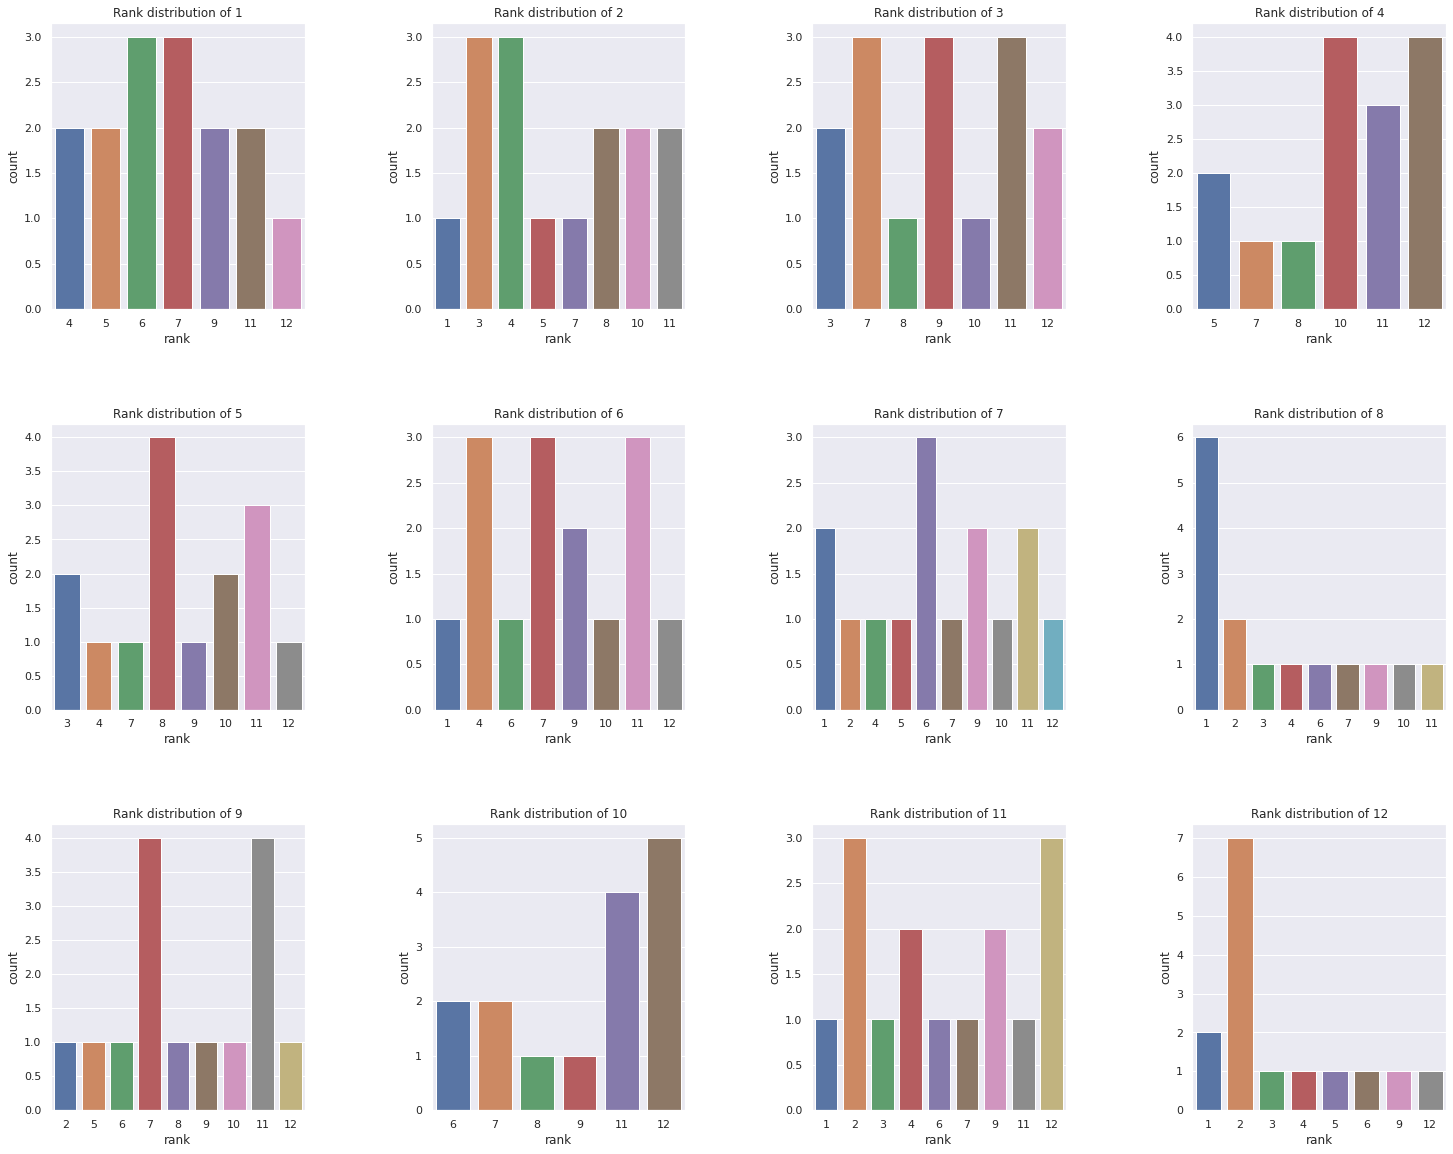

In [91]:
plot_month_rank(df_title_count)

---
- April and October are clearly the most popular months whereas January, August and December are least popular. 

---

## Is there specific week days to publish talk?

In [92]:
day_df = pd.DataFrame(df['week_day'].value_counts()).reset_index()
day_df.columns = ['week_day', 'ntalk']

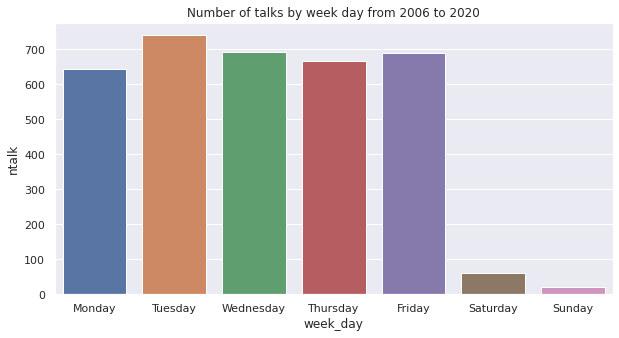

In [93]:
plt.figure(figsize=(10,5))
plt.title('Number of talks by week day from 2006 to 2020')
sns.barplot(x='week_day', y='ntalk', data=day_df, order=day_order)

In [94]:
# Plot bar chart of number of talks had been given group by week days from 2006 to 2020 
def plot_talks_by_year_weekday(df):
  df_group = df.groupby(by=['year'])['week_day'].value_counts().rename('ntalk').reset_index()
  
  fig, axes = plt.subplots(math.ceil(len(years)/4), 4, figsize=(25, 20))
  fig.subplots_adjust(hspace=0.5, wspace=0.4)
  i, j = 0 , 0
  
  for year in years:
    g = sns.barplot(x='week_day', y='ntalk', data=df_group[df_group['year'] == year], order=day_order, ax=axes[i, j])
    axes[i, j].set_title(f"Number of talks by week days in {year}")
    g.set_xticklabels(day_order, rotation = 30)
    if j == 3:
      i, j = i + 1, 0
    else:
      j = j + 1

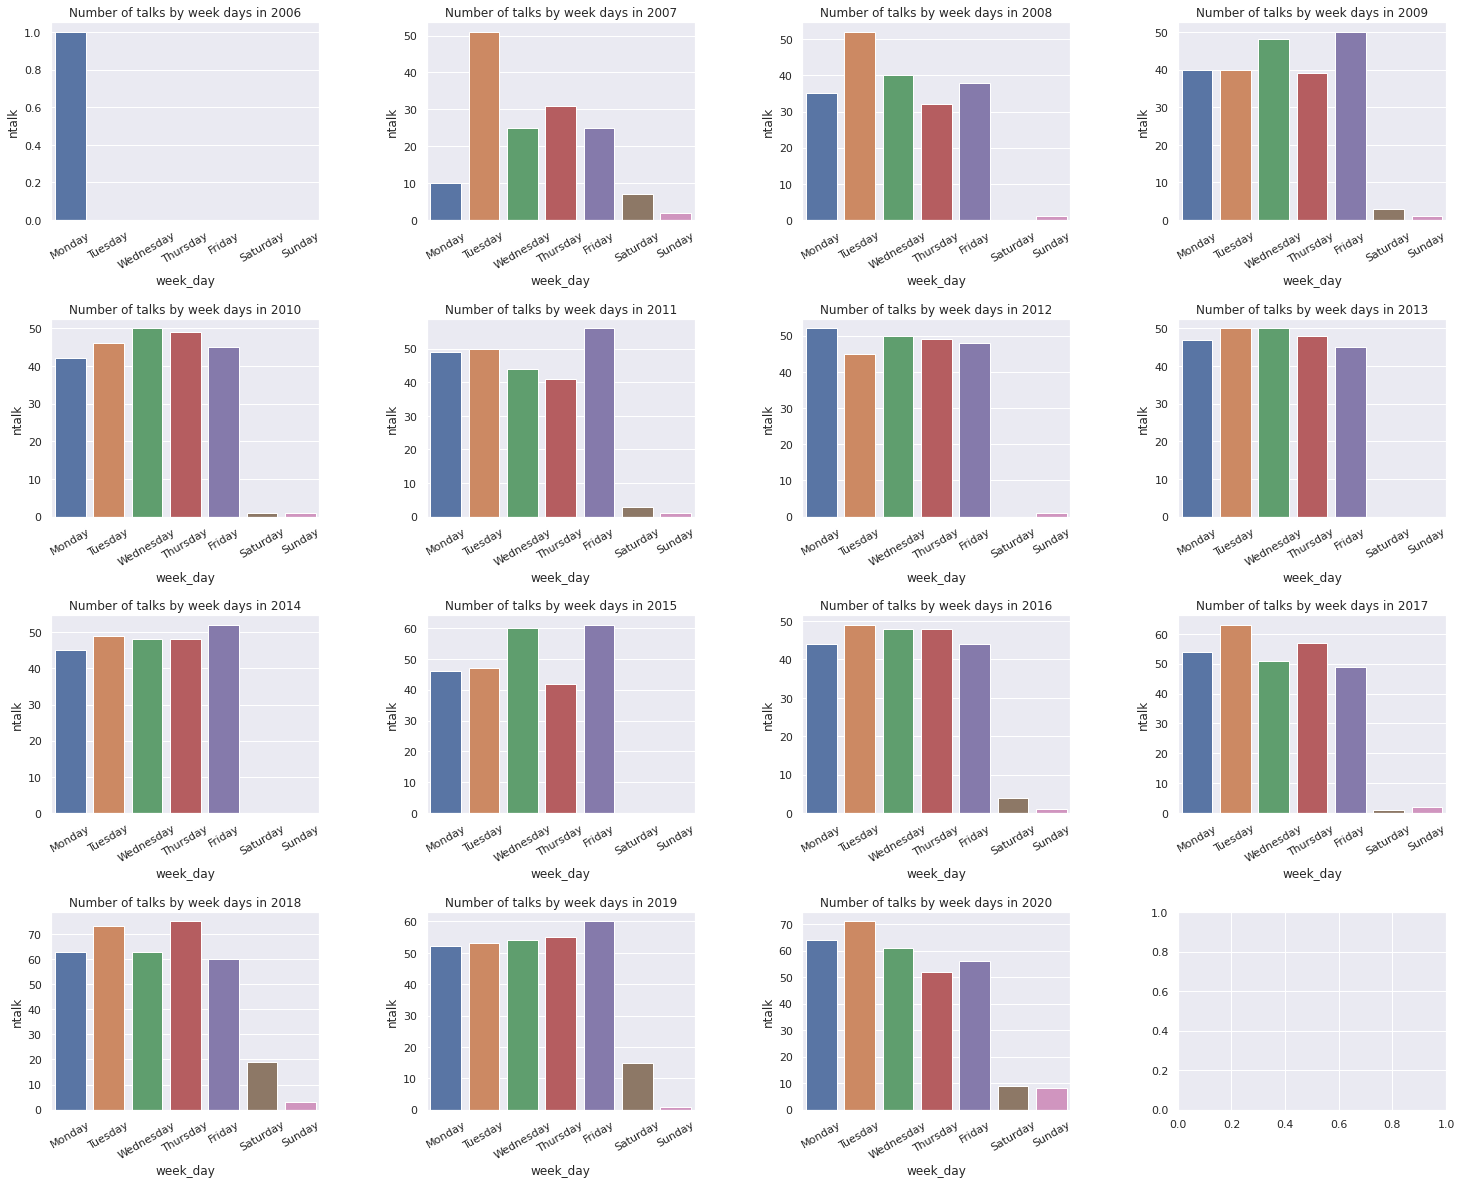

In [95]:
plot_talks_by_year_weekday(df)

---
**What is the most and least popular weekdays?**

Almost talks was posted on weekday rather than weekend and this schedule is being kept until now.

---

## The sooner the video's public date the more views this talk gets?

In [96]:
def plot_boxplot_by_year(df, feature):
  plt.figure(figsize=(18,5))
  sns.boxplot(data=df, x='year', y=feature)

In [97]:
def scatter_plot(df, x, y, alpha=1):
  plt.figure(figsize=(15,5))
  sns.scatterplot(data=df, x=x, y=y, alpha=1)

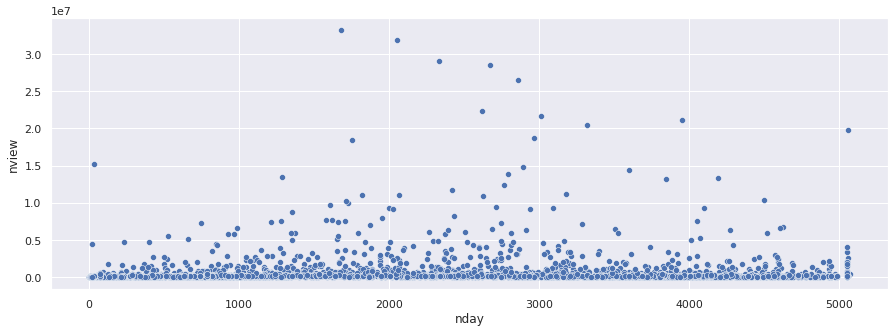

In [98]:
scatter_plot(df, "nday", "nview")

In [99]:
df[df['nview'] > 0.1e+07].groupby('year')['title'].count().reset_index(name='ntalk_cut_off')

,year,ntalk_cut_off
0,2007,18
1,2008,22
2,2009,19
3,2010,19
4,2011,21
5,2012,32
6,2013,43
7,2014,33
8,2015,37
9,2016,33


The cut off data points account for about 10%


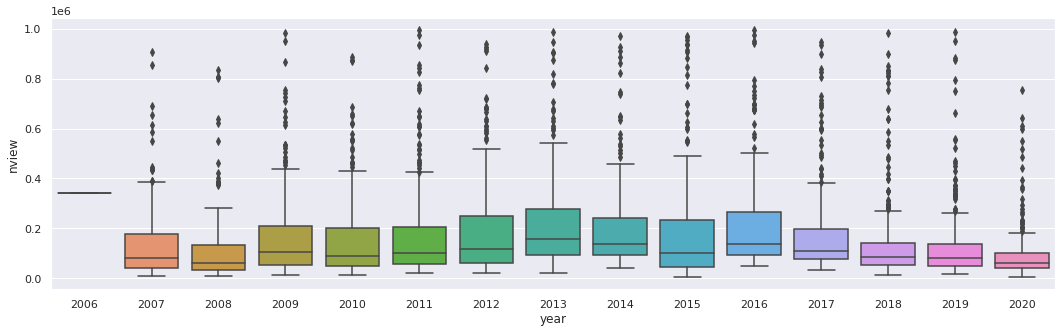

In [100]:
# Box plot of dataset cut off talks which nview belows 1 million views
df_cut_off = df[df['nview'] < 0.1e+07]
cut_off_prop = round(100*len(df[df['nview'] > 0.1e+07])/len(df))
print(f"The cut off data points account for about {cut_off_prop}%")
plot_boxplot_by_year(df_cut_off, 'nview')

In [101]:
import scikit_posthocs as sp

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0.05 else 'black'
    return 'color: %s' % color

def dunn_test(df, feature):
  data = [df.loc[df['year'] == year, feature] for year in years]
  res = sp.posthoc_dunn(data, p_adjust = 'bonferroni')
  res.columns = years
  res.index = years
  return (res.style.applymap(color_negative_red))

In [102]:
# Dunn's test on cut-off dataset 
dunn_test(df[df['nview'] < 0.5e+07], 'nview')

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
2006,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2007,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000001,0.000160,1.000000,0.000024,0.425670,1.000000,1.000000,0.000016
2008,1.000000,1.000000,1.000000,0.043662,0.167335,0.001977,0.000002,0.000000,0.000000,0.000733,0.000000,0.000000,1.000000,1.000000,0.861171
2009,1.000000,1.000000,0.043662,1.000000,1.000000,1.000000,1.000000,0.000001,0.000462,1.000000,0.000062,1.000000,1.000000,1.000000,0.000000
2010,1.000000,1.000000,0.167335,1.000000,1.000000,1.000000,1.000000,0.000000,0.000030,1.000000,0.000003,0.322298,1.000000,1.000000,0.000000
2011,1.000000,1.000000,0.001977,1.000000,1.000000,1.000000,1.000000,0.000031,0.006338,1.000000,0.000992,1.000000,0.519940,0.205623,0.000000
2012,1.000000,1.000000,0.000002,1.000000,1.000000,1.000000,1.000000,0.019773,0.948630,1.000000,0.247809,1.000000,0.001517,0.000540,0.000000
2013,1.000000,0.000001,0.000000,0.000001,0.000000,0.000031,0.019773,1.000000,1.000000,0.000065,1.000000,0.046080,0.000000,0.000000,0.000000
2014,1.000000,0.000160,0.000000,0.000462,0.000030,0.006338,0.948630,1.000000,1.000000,0.012025,1.000000,1.000000,0.000000,0.000000,0.000000
2015,1.000000,1.000000,0.000733,1.000000,1.000000,1.000000,1.000000,0.000065,0.012025,1.000000,0.001958,1.000000,0.240195,0.091927,0.000000


In [103]:
# Dunn's test on full dataset
dunn_test(df, 'nview')

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
2006,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2007,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.535627,0.000000,0.000062,1.000000,0.000003,0.250337,1.000000,1.000000,0.000020
2008,1.000000,1.000000,1.000000,0.055192,0.474846,0.003428,0.000002,0.000000,0.000000,0.000522,0.000000,0.000000,1.000000,1.000000,0.291022
2009,1.000000,1.000000,0.055192,1.000000,1.000000,1.000000,1.000000,0.000001,0.000586,1.000000,0.000022,1.000000,1.000000,1.000000,0.000000
2010,1.000000,1.000000,0.474846,1.000000,1.000000,1.000000,0.477335,0.000000,0.000011,1.000000,0.000000,0.190789,1.000000,1.000000,0.000000
2011,1.000000,1.000000,0.003428,1.000000,1.000000,1.000000,1.000000,0.000013,0.006161,1.000000,0.000292,1.000000,0.350493,0.101460,0.000000
2012,1.000000,0.535627,0.000002,1.000000,0.477335,1.000000,1.000000,0.015541,1.000000,1.000000,0.146840,1.000000,0.000491,0.000115,0.000000
2013,1.000000,0.000000,0.000000,0.000001,0.000000,0.000013,0.015541,1.000000,1.000000,0.000073,1.000000,0.021854,0.000000,0.000000,0.000000
2014,1.000000,0.000062,0.000000,0.000586,0.000011,0.006161,1.000000,1.000000,1.000000,0.024707,1.000000,1.000000,0.000000,0.000000,0.000000
2015,1.000000,1.000000,0.000522,1.000000,1.000000,1.000000,1.000000,0.000073,0.024707,1.000000,0.001395,1.000000,0.070490,0.018664,0.000000


---
**The earlier public day the more view this talk gets?**
- Talks which have big quantity of views lie around 1800 to 3000 days (5 to 8 years ago, 2012 to 2015). 
- There are 2 talks in 2020 have markedly high number of views even though they just were posted these months.
- In the scatter plot, there are some outliers which makes it hard to observe, hence in the box plot, I cut off at 'nview' < 1,000,000. We see that the mean nview of years from 2007 to 2011 is not significantly different from those in 2018 and 2019 => the earlier the talk gave does not mean the more views it tends to get.
- The average number of watches are not much different through years => the number of views of each talk will increase to a number (100,000 views). 
- The mean of nview from 2012 to 2017 excluded 2013 and 2014 are not different. 
---

## Videos have significant high views in 2020

In [104]:
df[df['year'] == 2020].sort_values('nview', ascending=False)[:10]

,title,yid,public_date,event,nview,nlike,ndislike,ncomment,speaker,year,month,week_day,nview_per_like,nview_per_dislike,nday,nview_per_day
2020,[Full livestream] Watch the Countdown Global L...,5dVcn8NjbwY,2020-10-10,TED,15215040,31845,9149,0,,2020,10,Saturday,477.784268,1663.027653,33,461061.818182
2517,How we must respond to the coronavirus pandemic,Xe8fIjxicoo,2020-03-25,TED,4679732,72948,9697,18252,Bill Gates,2020,3,Wednesday,64.151615,482.595854,232,20171.258621
630,What if a US presidential candidate refuses to...,WZWRhLW7Y8w,2020-10-26,TED,4413510,138592,13064,40253,Van Jones,2020,10,Monday,31.845345,337.837569,17,259618.235294
825,How the pandemic will shape the near future,jmQWOPDqxWA,2020-07-06,TED,1683835,28209,16378,19760,Bill Gates,2020,7,Monday,59.691411,102.810783,129,13052.984496
2768,What coronavirus means for the global economy,yrxYhv2O3wU,2020-04-09,TED,1676514,27537,1084,3398,Ray Dalio,2020,4,Thursday,60.882231,1546.599631,217,7725.870968
2373,Why 1.5 billion people eat with chopsticks,tSciinXdGhI,2020-01-21,TED,1353862,38800,1588,2836,"Small Thing Big Idea, a TED series",2020,1,Tuesday,34.893351,852.557935,296,4573.858108
1879,The perks of being a pirate,KzIp4IzDPG0,2020-03-09,TED,753556,30670,384,1366,Tom Nash,2020,3,Monday,24.569808,1962.385417,248,3038.532258
1237,Give yourself permission to be creative,WRS9Gek4V5Q,2020-08-11,TED,642468,50683,219,1790,Ethan Hawke,2020,8,Tuesday,12.676203,2933.643836,93,6908.258065
1487,How menopause affects the brain,JJZ8z_nTCZQ,2020-04-13,TED,610986,19228,395,1258,Lisa Mosconi,2020,4,Monday,31.775848,1546.800000,213,2868.478873
2845,How the coronavirus pandemic is changing the w...,ldKtWp7jlHI,2020-04-13,TED,596922,7788,843,1441,Fareed Zakaria,2020,4,Monday,76.646379,708.092527,213,2802.450704


---
**Observation**
- The topics of 3 videos having largest number of views are climate change, the coronavirus pandemic and US election. 
- "Watch the Countdown Global Launch, a call to action on climate change" has the biggest views in short time, however, it is a combination of many sessions with more than 50 speakers, activists, actors and musicians. In addition, the quantity of interactions (like, dislike and comment) is pretty lower than the 2nd and 3rd ones.
- The third video - "What if a US presidential candidate refuses to concede after an election?" is the shortest in term video length and latest in public date but owns highest interactions (like, dislike and comment). It seems to be an interesting topic people more concern about before the US election in November.      
---

## Correlation between views, likes, dislikes and comments

In [134]:
df_off_cmt = df[df['ncomment'] != 0].copy()
df_off_cmt['ncomment'] = df_off_cmt['ncomment'].astype('int32')
df_off_cmt.corr(method='kendall')

,nview,nlike,ndislike,ncomment,year,month,nview_per_like,nview_per_dislike,nday,nview_per_day,rank_nview,rank_nlike,rank_ndislike,rank_ncomment,rank_nview_per_like,rank_nview_per_dislike,nview_per_comment
nview,1.000000,0.699895,0.443558,0.547273,-0.072498,-0.022297,0.012978,0.238759,0.073220,0.513654,-1.000000,-0.699895,-0.443558,-0.547273,0.012668,0.237929,0.207764
nlike,0.699895,1.000000,0.498486,0.620392,0.177044,-0.009490,-0.285877,0.111201,-0.168750,0.681652,-0.699895,-1.000000,-0.498486,-0.620392,-0.287520,0.108644,0.043149
ndislike,0.443558,0.498486,1.000000,0.646904,0.185189,-0.002242,-0.172765,-0.317985,-0.177471,0.483793,-0.443558,-0.498486,-1.000000,-0.646904,-0.174671,-0.319557,-0.197121
ncomment,0.547273,0.620392,0.646904,1.000000,0.117841,0.010149,-0.206159,-0.093585,-0.114154,0.514387,-0.547273,-0.620392,-0.646904,-1.000000,-0.205640,-0.093326,-0.245563
year,-0.072498,0.177044,0.185189,0.117841,1.000000,0.001285,-0.616747,-0.327106,-0.962532,0.423541,0.072498,-0.177044,-0.185189,-0.117841,-0.614248,-0.325272,-0.275457
month,-0.022297,-0.009490,-0.002242,0.010149,0.001285,1.000000,-0.030629,-0.036216,-0.071577,0.012554,0.022297,0.009490,0.002242,-0.010149,-0.029269,-0.034844,-0.051917
nview_per_like,0.012978,-0.285877,-0.172765,-0.206159,-0.616747,-0.030629,1.000000,0.228832,0.597041,-0.354842,-0.012978,0.285877,0.172765,0.206159,1.000000,0.228832,0.329082
nview_per_dislike,0.238759,0.111201,-0.317985,-0.093585,-0.327106,-0.036216,0.228832,1.000000,0.318276,-0.019256,-0.238759,-0.111201,0.317985,0.093585,0.228832,1.000000,0.519913
nday,0.073220,-0.168750,-0.177471,-0.114154,-0.962532,-0.071577,0.597041,0.318276,1.000000,-0.413215,-0.073220,0.168750,0.177471,0.114154,0.594532,0.316409,0.269961
nview_per_day,0.513654,0.681652,0.483793,0.514387,0.423541,0.012554,-0.354842,-0.019256,-0.413215,1.000000,-0.513654,-0.681652,-0.483793,-0.514387,-0.353292,-0.018479,-0.025898


In [135]:
df.corr(method='kendall')

,nview,nlike,ndislike,ncomment,year,month,nview_per_like,nview_per_dislike,nday,nview_per_day,rank_nview,rank_nlike,rank_ndislike,rank_ncomment,rank_nview_per_like,rank_nview_per_dislike,nview_per_comment
nview,1.000000,0.694072,0.439737,0.530222,-0.070309,-0.021678,0.013105,0.237407,0.071022,0.516846,-1.000000,-0.694072,-0.439737,-0.530222,0.015206,0.237725,0.207764
nlike,0.694072,1.000000,0.502984,0.611111,0.174903,-0.005451,-0.285124,0.109596,-0.167039,0.676763,-0.694072,-1.000000,-0.502984,-0.611111,-0.290800,0.100787,0.043149
ndislike,0.439737,0.502984,1.000000,0.638435,0.183518,0.001126,-0.172791,-0.318152,-0.176172,0.480559,-0.439737,-0.502984,-1.000000,-0.638435,-0.179367,-0.323573,-0.197121
ncomment,0.530222,0.611111,0.638435,1.000000,0.118710,0.011464,-0.206852,-0.095443,-0.115103,0.501986,-0.530222,-0.611111,-0.638435,-1.000000,-0.210777,-0.100251,-0.245563
year,-0.070309,0.174903,0.183518,0.118710,1.000000,0.001065,-0.616339,-0.327569,-0.962586,0.422550,0.070309,-0.174903,-0.183518,-0.118710,-0.608354,-0.321874,-0.275457
month,-0.021678,-0.005451,0.001126,0.011464,0.001065,1.000000,-0.030942,-0.036424,-0.071268,0.012860,0.021678,0.005451,-0.001126,-0.011464,-0.031829,-0.037268,-0.051917
nview_per_like,0.013105,-0.285124,-0.172791,-0.206852,-0.616339,-0.030942,1.000000,0.230084,0.596636,-0.353178,-0.013105,0.285124,0.172791,0.206852,1.000000,0.230084,0.329082
nview_per_dislike,0.237407,0.109596,-0.318152,-0.095443,-0.327569,-0.036424,0.230084,1.000000,0.318678,-0.020111,-0.237407,-0.109596,0.318152,0.095443,0.230084,1.000000,0.519913
nday,0.071022,-0.167039,-0.176172,-0.115103,-0.962586,-0.071268,0.596636,0.318678,1.000000,-0.412220,-0.071022,0.167039,0.176172,0.115103,0.589028,0.313279,0.269961
nview_per_day,0.516846,0.676763,0.480559,0.501986,0.422550,0.012860,-0.353178,-0.020111,-0.412220,1.000000,-0.516846,-0.676763,-0.480559,-0.501986,-0.347223,-0.016802,-0.025898


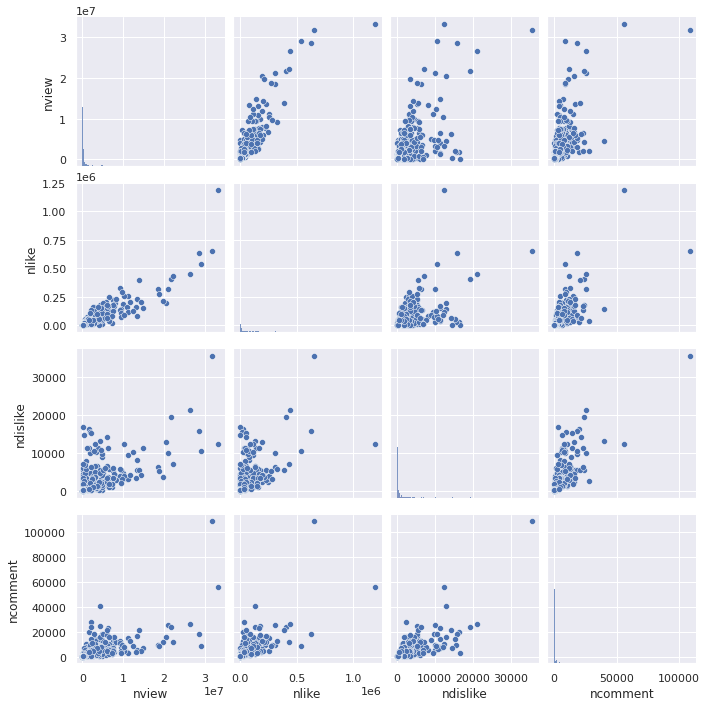

In [136]:
sns.pairplot(df_off_cmt[['nview', 'nlike', 'ndislike', 'ncomment']])

## Videos of all time

In [137]:
df['rank_nview'] = df['nview'].rank(method='max', ascending = False)
df['rank_nlike'] = df['nlike'].rank(method='max', ascending = False)
df['rank_ndislike'] = df['ndislike'].rank(method='max', ascending = False)
df['rank_ncomment'] = df['ncomment'].rank(method='max', ascending = False)
df['rank_nview_per_like'] = df['nview_per_like'].rank(method='max', ascending = True)
df['rank_nview_per_dislike'] = df['nview_per_dislike'].rank(method='max', ascending = True)
df['rank_nview_per_comment'] = df['nview_per_comment'].rank(method='max', ascending = True)

In [149]:
df.sort_values(by=['rank_nlike'], ascending=True)[:10]

,title,yid,public_date,event,nview,nlike,ndislike,ncomment,speaker,year,month,week_day,nview_per_like,nview_per_dislike,nday,nview_per_day,rank_nview,rank_nlike,rank_ndislike,rank_ncomment,rank_nview_per_like,rank_nview_per_dislike,nview_per_comment,rank_nview_per_comment
3291,Inside the mind of a master procrastinator,arj7oStGLkU,2016-04-06,TED,33260825,1191320,12490,55552,Tim Urban,2016,4,Wednesday,27.919304,2662.996397,1681,19786.332540,1.0,1.0,14.0,2.0,192.0,2867.0,598.733169,1712.0
2300,The next outbreak? We’re not ready,6Af6b_wyiwI,2015-04-03,TED,31832791,650948,35777,108459,Bill Gates,2015,4,Friday,48.902203,889.755737,2050,15528.190732,2.0,2.0,1.0,1.0,1240.0,1327.0,293.500687,643.0
2208,The orchestra in my mouth,DFjIi2hxxf0,2013-07-19,TED,28548848,629841,15855,18127,Tom Thum,2013,7,Friday,45.327071,1800.621129,2673,10680.451927,4.0,3.0,6.0,16.0,1051.0,2341.0,1574.935069,3065.0
2218,How to speak so that people want to listen,eIho2S0ZahI,2014-06-27,TED,29097584,541571,10473,8413,Julian Treasure,2014,6,Friday,53.728106,2778.342786,2330,12488.233476,3.0,4.0,24.0,66.0,1430.0,2921.0,3458.645430,3418.0
3340,"Looks aren't everything. Believe me, I'm a model.",KM4Xe6Dlp0Y,2013-01-16,TED,26515480,446131,21260,25713,Cameron Russell,2013,1,Wednesday,59.434292,1247.200376,2857,9280.882044,5.0,5.0,2.0,5.0,1667.0,1792.0,1031.209116,2590.0
2925,The art of misdirection,GZGY0wPAnus,2013-09-13,TED,22283484,432349,7178,11690,Apollo Robbins,2013,9,Friday,51.540501,3104.414043,2617,8514.896446,6.0,6.0,37.0,40.0,1346.0,3036.0,1906.200513,3189.0
2640,Strange answers to the psychopath test,xYemnKEKx0c,2012-08-15,TED,21643792,407789,19411,23853,Jon Ronson,2012,8,Wednesday,53.075958,1115.027150,3011,7188.240452,7.0,7.0,3.0,8.0,1405.0,1638.0,907.382384,2404.0
2699,My escape from North Korea,PdxPCeWw75k,2013-03-20,TED,13862515,392524,5571,20899,Hyeonseo Lee,2013,3,Wednesday,35.316350,2488.335128,2794,4961.530064,16.0,8.0,53.0,12.0,518.0,2773.0,663.309967,1892.0
2600,How to control someone else's arm with your brain,rSQNi5sAwuc,2015-04-28,TED,9151789,327212,5714,12370,Greg Gage,2015,4,Tuesday,27.968990,1601.643157,2025,4519.401975,34.0,9.0,51.0,34.0,195.0,2177.0,739.837429,2094.0
2441,What makes a good life? Lessons from the longe...,8KkKuTCFvzI,2016-01-25,TED,18422807,314541,6354,9021,Robert Waldinger,2016,1,Monday,58.570447,2899.403053,1753,10509.302339,12.0,10.0,45.0,61.0,1626.0,2967.0,2042.213391,3240.0


## Videos which get most disagree

In [151]:
df[df['nlike'] < df['ndislike']].sort_values(by=['ndislike'], ascending=False)

,title,yid,public_date,event,nview,nlike,ndislike,ncomment,speaker,year,month,week_day,nview_per_like,nview_per_dislike,nday,nview_per_day,rank_nview,rank_nlike,rank_ndislike,rank_ncomment,rank_nview_per_like,rank_nview_per_dislike,nview_per_comment,rank_nview_per_comment
1663,Why kids need to learn about gender and sexuality,OQuwz64qsBM,2019-08-05,TED,161935,3970,16771,2963,Lindsay Amer,2019,8,Monday,40.789673,9.655656,465,348.247312,1307.0,960.0,4.0,186.0,791.0,1.0,54.652379,13.0
2919,An interview with the founders of Black Lives ...,tbicAmaXYtM,2016-12-20,TED,318014,3788,14665,6624,"Alicia Garza, Patrisse Cullors, Opal Tometi",2016,12,Tuesday,83.953010,21.685237,1423,223.481377,775.0,1006.0,9.0,88.0,2418.0,7.0,48.009360,9.0
3408,Why we need gender-neutral bathrooms,XAcARiiK5uY,2016-03-18,TED,176833,4530,7011,2741,Ivan Coyote,2016,3,Friday,39.035982,25.222222,1700,104.019412,1209.0,856.0,38.0,199.0,699.0,12.0,64.514046,21.0
617,We should all be feminists,S6ufvYWTqQ0,2017-05-15,TED,144579,5840,6096,1536,Chimamanda Ngozi Adichie,2017,5,Monday,24.756678,23.717028,1277,113.217698,1428.0,700.0,47.0,323.0,105.0,10.0,94.126953,68.0
2104,The data behind Hollywood's sexism,7kkRkhAXZGg,2017-03-21,TED,101959,2066,4310,1203,Stacy Smith,2017,3,Tuesday,49.350920,23.656381,1332,76.545796,1886.0,1696.0,71.0,398.0,1260.0,9.0,84.753948,55.0
2258,The trauma of systematic racism is killing Bla...,8olL43PKJKw,2017-06-12,TED,115622,2382,3907,1013,,2017,6,Monday,48.539882,29.593550,1249,92.571657,1700.0,1500.0,80.0,457.0,1221.0,16.0,114.138203,104.0
554,How diversity makes teams more innovative,lPtPG2lAmm4,2017-11-15,TED,111052,1133,3379,746,Rocío Lorenzo,2017,11,Wednesday,98.015887,32.865345,1093,101.602928,1752.0,2452.0,96.0,578.0,2704.0,20.0,148.863271,171.0
658,What will you tell your daughters about 2016?,VSUWNy_-pLI,2016-12-22,TED,94765,2556,3364,932,Chinaka Hodge,2016,12,Thursday,37.075509,28.170333,1421,66.688951,1989.0,1414.0,97.0,485.0,612.0,15.0,101.679185,82.0
3398,Why your doctor should care about social justice,E_NiCniw0JE,2016-03-17,TED,58888,719,3356,582,Mary Bassett,2016,3,Thursday,81.902643,17.547080,1701,34.619636,2668.0,2862.0,98.0,721.0,2374.0,3.0,101.182131,78.0
2565,It's time for women to run for office,uYaF8p_TNSU,2016-12-01,TED,49694,1117,3096,718,Halla Tómasdóttir,2016,12,Thursday,44.488809,16.051034,1442,34.461859,2876.0,2468.0,113.0,597.0,999.0,2.0,69.211699,27.0
